In [78]:
#HyperParameters

input_dim = 1 #입력하는 feature 개수
#time_interval = 8 #minute. n분 마다 n분 누적 신호 발생. 혹은 lstm cell에서 시계열의 갯수
min_transaction_amount = 5000000 # 100만원 미만이면 리시버에서 버퍼로 데이터 안보내게끔.
n_cell = 32 # LSTM셀의 개수
n_labels = 4 #모델의 결과 값 라벨 수 e.g. n=4, 라벨이 강하락, 약하락, 약상승, 강상승 신호 발생.
seq_length = 60 # 모델이 참고 할 이전 분봉의 개수. LSTM/RNN에서
lr = 0.003 # 학습률
keep_prob = 1.0 #dropout rate
n_stacked_layers = 1 # 모델의 레이어 개수
n_epochs = 3 # 학습횟수. 얼리스타핑 넣을까말까
n_batch_size = 32 #학습 배치 사이즈
model_path = None

In [98]:
data1

,time,price,amount,state,feature,1분후,label
0,2020-06-04 09:03:34,91200,1,-1,-91200,91000.0,0.997807
1,2020-06-04 09:03:34,91200,909,-1,-82900800,91000.0,0.997807
2,2020-06-04 09:03:34,91200,1,-1,-91200,91000.0,0.997807
3,2020-06-04 09:03:34,91200,16,-1,-1459200,91000.0,0.997807
4,2020-06-04 09:03:34,91200,10,-1,-912000,91000.0,0.997807
...,...,...,...,...,...,...,...
66576,2020-06-04 15:19:22,87800,21,-1,-1843800,NaN,NaN
66577,2020-06-04 15:19:22,87800,6,-1,-526800,NaN,NaN
66578,2020-06-04 15:19:22,87800,96,-1,-8428800,NaN,NaN
66579,2020-06-04 15:19:22,87800,1,-1,-87800,NaN,NaN


In [101]:
data1[data1['state']==1]

,time,price,amount,state,feature,1분후,label
1,2020-06-04 09:04:58,208000,2,1,416000,207500.0,0.997596
2,2020-06-04 09:04:59,208000,90,1,18720000,207500.0,0.997596
6,2020-06-04 09:04:59,208000,38,1,7904000,207500.0,0.997596
7,2020-06-04 09:04:59,208000,5,1,1040000,207500.0,0.997596
8,2020-06-04 09:04:59,208000,11,1,2288000,207500.0,0.997596
...,...,...,...,...,...,...,...
20401,2020-06-04 15:19:09,201500,2,1,403000,NaN,NaN
20402,2020-06-04 15:19:10,201500,9,1,1813500,NaN,NaN
20403,2020-06-04 15:19:10,201500,1,1,201500,NaN,NaN
20405,2020-06-04 15:19:18,201500,10,1,2015000,NaN,NaN


In [106]:
##########오전시간까지 포함된 데이터에 대해서###########
#################1분1초 3초 5초에 대한 코드 추가 -> 데이터확인해봐야함
import pandas as pd
import datetime
import numpy as np
import math
import openpyxl
import os
time_lst=[]
price_lst=[] #체결가
temp_lst=[] # 1: 매수 2:매도
amount_lst=[] #체결수량
state_lst=[]
feature_lst=[]
after_price_lst=[]
rate_lst=[]
label_lst=[]

def func1():
    file_name="20200604005930.txt"
    in_file=open(file_name,"r") #file open

    in_str=in_file.read() #file read
    lst=in_str.split(')') # split
    new_lst=[]
    for el in lst :
        new_lst.append(el.lstrip(', ('))
    new_lst=list(filter(None,new_lst))
    #########################################리스트에 생성##################3
    time_lst=[]
    for el in new_lst:
        lst2 = el.split(',')
        #time=datetime.datetime.strptime(lst2[1].lstrip("' ").rstrip("' "),'%H%M%S')
        time = lst2[1].lstrip("' ").rstrip("' ")
        if(len(time)<14):
            time=time[:8]+'0'+time[8:13]
        time = datetime.datetime.strptime(time,"%Y%m%d%H%M%S")
        time_lst.append(time)  # 시간리스트에 추가
        price_lst.append(int(lst2[4]))  # 체결가 리스트에 추가
        amount_lst.append(int(lst2[8]))

        temp=lst2[6].lstrip(" '").rstrip(" '")
        state=int(temp)
        if(state==1) :
            state_lst.append(1)
        else:
            state_lst.append(-1)
    print(len(time_lst),len(price_lst),len(state_lst),len(amount_lst))
    time_lst = pd.to_datetime(time_lst)
    raw_data = {'time': time_lst, 'price': price_lst,'amount':amount_lst,'state':state_lst}
    data = pd.DataFrame(raw_data)

    in_file.close()
    return data
data1=func1()
#############체결가 X 체결량 X 상태 (피처값)열, 1분후 열 추가########################################
for i in range(len(data1)) :
    feature=data1.loc[i]['price'] *data1.loc[i]['amount'] * data1.loc[i]['state']
    #print(feature)
    feature_lst.append(feature)

    is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1)  # 각 행에대해서 1분 후의 가격이 존재하면 리스트에 추가
    temp = data1[is_time].reset_index(drop=True)
    if (temp.empty == False):
        after_price_lst.append(temp.loc[0]['price'])
    else:  # 1분후 값이 존재하지 않는 부분 1분 1초후 or  nan으로 채움
        is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=1)
        temp = data1[is_time].reset_index(drop=True)
        if (temp.empty == False):
            after_price_lst.append(temp.loc[0]['price'])
        else:
            is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=3)
            temp = data1[is_time].reset_index(drop=True)
            if (temp.empty == False):
                after_price_lst.append(temp.loc[0]['price'])
            else:
                is_time = data1['time'] == data1.loc[i]['time'] + datetime.timedelta(minutes=1, seconds=5)
                temp = data1[is_time].reset_index(drop=True)
                if (temp.empty == False):
                    after_price_lst.append(temp.loc[0]['price'])
                else:
                    after_price_lst.append(np.nan)

data1['feature']=feature_lst
data1['1분후'] = after_price_lst
#############상승률 (label)열 추가########################################
for i in range(len(data1)):
    if(data1.loc[i]['1분후']!=np.nan) :
        rate=data1.loc[i]['1분후']/data1.loc[i]['price']
    else :
        rate=np.nan
    rate_lst.append(rate)
data1['label']=rate_lst

#print(data1.head(10))
###################################################임계치 넘는 값,  결측치 아닌값에 대해서만 train set을 df에저장
df=data1[abs(data1['feature'])>=min_transaction_amount]
df=df.dropna()
#print(df.head(20))



X_list=df.feature.tolist()
label_list=df.label.tolist()
print(len(X_list),len(label_list))

#################feature 값 3차원 array로 데이터 변환################

sample_num=0
feature_lst_3dim=[]
for i in range(len(X_list)-seq_length+1) :
        temp=X_list[i:i+seq_length] # temp는 1차원 list
        arr=np.array([temp]).T # arr는 temp를 배열로 변환후 transpose
        arr=arr.tolist() # 다시 리스트로 바꾸어
        feature_lst_3dim.append(arr) #최종 리스트에 추가
        sample_num=sample_num+1
print("데이터 샘플의 갯수: ",sample_num)
print("시계열의 크기 : ",seq_length)
X_arr=np.array(feature_lst_3dim) # list를 3차원 array로 변환
print(X_arr.shape)
#X_arr = feature 가 저장된 3차원 array
#################label 값 3차원 array로 데이터 변환################
label_len=0
label_lst_2dim=[]
for i in range(seq_length-1,len(label_list),1):
    temp=[]
    temp.append(label_list[i])
    label_lst_2dim.append(temp)
    label_len=label_len+1
Y_arr=np.array(label_lst_2dim)
print("라벨의 갯수: ",label_len)
print(Y_arr.shape)
#print(Y_arr)
# Y_arr = label이 저장된 3차원 array


base_dir="./"
file_nm="PreprocessingData.xlsx"
xlsx_dir=os.path.join(base_dir,file_nm)

df.to_excel(xlsx_dir)

134047 134047 134047 134047
33991 33991
데이터 샘플의 갯수:  33932
시계열의 크기 :  60
(33932, 60, 1)
라벨의 갯수:  33932
(33932, 1)


In [19]:
X_arr.shape

(65358, 60, 1)

In [102]:
from keras import Sequential
from keras.models import load_model
from keras.layers import Dense, Activation, LSTM
# Model Training & Saving
# 모델 생성 및 학습. 결과 저장

"""모델 라벨값은 총 4개. 0,1,2,3 으로 라벨링하고 
0(강 하락)에 매도, 1(약 하락), 2(약 상승)에 홀드or관망, 3(강 상승)에 매수"""

from keras import metrics

model = Sequential()
for i in range(n_stacked_layers):
    model.add(LSTM(n_cell, input_shape=(seq_length, input_dim), activation='sigmoid',weights=None))
model.add(Dense(1, input_shape=(1,)))

model.compile(loss='mse', optimizer='adam')
#어떤 loss func, optimizer를 써야할지, 메트릭스를 써야할지 모르겠다. 일단 나중에 생각하기.
history = model.fit(x = X_arr, y = Y_arr, epochs = n_epochs, validation_split=0.3)
#밸리데이션셋은 이전 단계에서 햇음. 데이터를 트레인 테스트로 8:2로 나눈다음 8을 
#5.6 : 2.4로 트레인 : 밸릳 데이터로 나눔.

#모델 저장
model_path = f"./model_{datetime.datetime.now().strftime('%m%d_%H%M%S')}.h5"
model.save(model_path)
import matplotlib.pyplot as plt
plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#model.evaluate()
#model.save()

Train on 1815 samples, validate on 778 samples
Epoch 1/3
1815/1815 [==============================] - 2s 828us/step - loss: 0.8274 - val_loss: 0.4118
Epoch 2/3
1815/1815 [==============================] - 1s 645us/step - loss: 0.2008 - val_loss: 0.0857
Epoch 3/3
1815/1815 [==============================] - 1s 664us/step - loss: 0.0377 - val_loss: 0.0137


AttributeError: 'History' object has no attribute 'losses'

In [32]:
_ = model.predict(X_arr)

In [31]:
Y_arr

array([[0.99671053],
       [0.99671053],
       [0.99671053],
       ...,
       [0.99886234],
       [0.99886234],
       [0.99886234]])

In [91]:
X_arr[17000:]

array([[[-8064040000],
        [-8064040000],
        [-8064040000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       [[-8064040000],
        [-8064040000],
        [-8064040000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       [[-8064040000],
        [-8064040000],
        [-8055060000],
        ...,
        [-8064040000],
        [-8064040000],
        [-8064040000]],

       ...,

       [[-7717620000],
        [-7717620000],
        [-7726410000],
        ...,
        [-7717620000],
        [-7717620000],
        [-7726410000]],

       [[-7717620000],
        [-7726410000],
        [-7717620000],
        ...,
        [-7717620000],
        [-7726410000],
        [-7717620000]],

       [[-7726410000],
        [-7717620000],
        [-7726410000],
        ...,
        [-7726410000],
        [-7717620000],
        [-7717620000]]], dtype=int64)

In [45]:
Y_arr[1700:]

array([[1.0032967 ],
       [1.0032967 ],
       [1.0032967 ],
       ...,
       [0.99886234],
       [0.99886234],
       [0.99886234]])

In [25]:
dir(history)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

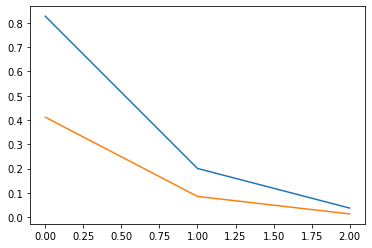

In [103]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
